# Data inspector

## 0. Imports

In [7]:
#To be at project directory root and not in the Notebooks folder
%cd /storage2/mwildi/CBS2

#Imports
import lmdb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import os
from tqdm import tqdm
import random
from collections import Counter
import cv2

/storage2/mwildi/CBS2


## 1. Read dataset

In [16]:
dataset_path = "dataset/111121/main"
repetitions = [x[0] for x in os.walk(dataset_path)][1:]
print('Found {} repetitions'.format(len(repetitions)))
print(repetitions)
#train_paths = [x[0] for x in os.walk(dataset_path + os.path.sep + 'train')][1:]
#val_paths = [x[0] for x in os.walk(dataset_path + os.path.sep + 'val')][1:]
#print('Found {} train episodes and {} val episodes'.format(len(train_paths), len(val_paths)))
#print(val_paths)

Found 14 repetitions
['dataset/111121/main/daoafupuzi', 'dataset/111121/main/xdpfdyiyow', 'dataset/111121/main/mzcvvseogz', 'dataset/111121/main/agtthkudhv', 'dataset/111121/main/mctwvnwnqa', 'dataset/111121/main/vgxxckpjvy', 'dataset/111121/main/icsgehmvyh', 'dataset/111121/main/xeynmtwqtk', 'dataset/111121/main/uqbplejcyt', 'dataset/111121/main/oivywugtrp', 'dataset/111121/main/trajyicuft', 'dataset/111121/main/ibniqbfdbo', 'dataset/111121/main/ezgwphphau', 'dataset/111121/main/yyymqvfchi']


### 1.1 Decode dataset

In [17]:
def decode_dataset(path):
    lmdb_env = lmdb.open(path)
    lmdb_txn = lmdb_env.begin()
    lmdb_cursor = lmdb_txn.cursor()

    out = dict()
    for key, value in tqdm(lmdb_cursor):
        out[key.decode("utf-8")] = value

    lmdb_cursor.close()
    return out

'''def decode_dataset(paths):
    outout = dict()
    n_episodes = len(paths)
    for i, path in enumerate(paths):
        print('ep.{}/{}'.format(i+1, n_episodes))
        lmdb_env = lmdb.open(path)
        lmdb_txn = lmdb_env.begin()
        lmdb_cursor = lmdb_txn.cursor()
        
        for key, value in tqdm(lmdb_cursor):
            out[key.decode("utf-8")] = value
            
        lmdb_cursor.close()
    return out'''

def decode_step_data(step_data, kind):
    if kind == 'tls':
        return np.frombuffer(step_data, dtype=np.uint8)
    if kind.find('wide_rgb') == -1:
        return np.frombuffer(step_data, dtype=np.float32)
    else:
        img = np.frombuffer(step_data, dtype=np.uint8)
        img = img.reshape((240, -1, 3))
        return img
        

def decode_step(dataset, step):
    data = {'lbl':None, 'loc':None, 'rot': None, 'spd':None, 'cmd':None, 'wide_rgb_0':None, 'wide_rgb_1':None, 'wide_rgb_2':None, 'tls':None}

    for t in data.keys():
        d = dataset["{}_{:05d}".format(t, step)]
        data[t] = decode_step_data(d, kind=t)

    return data

In [18]:
rep = decode_dataset(repetitions[0])
import math
total_frames = math.floor(len(rep)/18)
print(f'{total_frames} frames found')

1081it [00:00, 39346.05it/s]

60 frames found


In [19]:
step_data = decode_step(dataset=rep, step=2)
bv0=step_data['wide_rgb_0']
print(bv0.shape)

(240, 480, 3)


TLS: [1]


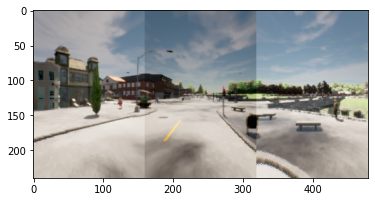

In [20]:
plt.imshow(cv2.cvtColor(bv0, cv2.COLOR_BGR2RGB))
print('TLS: {}'.format(step_data['tls']))
# 2: Green

In [13]:
import cv2
import numpy as np
import glob
 
img_array = []
for i in range(total_frames):
    step_data = decode_step(dataset=rep, step=i)
    img = step_data['wide_rgb_0']
    height, width, _ = img.shape
    size = (width,height)
    img_array.append(img)
out = cv2.VideoWriter('Notebooks/video.avi',cv2.VideoWriter_fourcc(*'DIVX'), 15, size)
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()

In [14]:
import math
def get_red_tl():
    is_red_tl = []
    speed = []
    for i in range(int(dataset['len'].decode())):
        is_red_tl.append(decode_frame(i)['trafficlights'])
    c = Counter(is_red_tl)
    n_red_frames = c[0]
    n_frames = sum(c.values())
    
    level_changes = 0
    for i,tl in enumerate(is_red_tl):
        if (i != 0 and tl != old_tl):
            level_changes += 1
        old_tl = tl
    red_lights = math.floor(level_changes/2)
    infos = [red_lights, n_red_frames, n_frames]
    
    return infos

def get_red_tl_by_cmd():
    is_red_tl = []
    speed = []
    for i in range(int(dataset['len'].decode())):
        if decode_frame(i)['trafficlights']:
            cmd = int(decode_frame(i)['measurements'][18])
            is_red_tl.append(cmd)
        else:
            is_red_tl.append(0)
    c = Counter(is_red_tl)
    print(c)
    no_red = c[0]
    red_l = c[1]
    red_r = c[2]
    red_s = c[3]
    red_f = c[4]
    n_frames = sum(c.values())
    n_red_frames = n_frames - no_red
    
    level_changes = 0
    for i,tl in enumerate(is_red_tl):
        if (i != 0 and tl != old_tl):
            level_changes += 1
        old_tl = tl
    red_lights = math.floor(level_changes/2)
    infos = [red_lights, n_red_frames, n_frames, red_l, red_r, red_s, red_f]
    
    return infos

In [15]:
path_list = val_paths
filename = 'val2.txt'
#ox, oy, oz, ori_ox, ori_oy, vx, vy, vz, _, _, _, _, _, _, ax, ay, az, cmd, steer, throttle, brake, manual, gear  = measurement

NameError: name 'val_paths' is not defined

In [ ]:
n_episodes = len(path_list)
episodes_tl_infos = np.zeros((n_episodes, 3))
with open(filename,"w") as savefile:     
    for i, path in enumerate(path_list):
        print('ep.{}/{}'.format(i, n_episodes))
        dataset = decode_dataset(path)
        print(len(dataset))
        if len(dataset) != 0:
            
            #row = get_red_tl()
            row = get_red_tl_by_cmd()
            print(row)
            np.savetxt(savefile, row, fmt='%i', delimiter=",")

In [ ]:
#save_tl_data(train_paths,'test.txt')

In [ ]:
#save_tl_data(train_paths, 'val.txt')

In [85]:
def retrieve_tl_infos(filename):
    retrieved = np.fromfile(filename, sep='\n').astype(int).reshape(-1,3)
    print('Retrieved {} episodes'.format(retrieved.shape[0]))
    red_lights = retrieved[:,0]
    n_red_frames = retrieved[:,1]
    n_frames = retrieved[:,2]
    return red_lights, n_red_frames, n_frames

def retrieve_tl_infos_cmd(filename):
    retrieved = np.fromfile(filename, sep='\n').astype(int).reshape(-1,7)
    print('Retrieved {} episodes'.format(retrieved.shape[0]))
    #print(retrieved)
    retrieved = np.sum(retrieved, axis=0) # Sum over all epsisodes
    total_infractions = retrieved[0]
    total_frames = retrieved[1] # Store total number of frames to compute rates PER FRAME
    rates = 100*retrieved[3:]/total_frames # Compute rates
    return total_frames, rates

Retrieved 142 episodes
Retrieved 33 episodes
[ 8.5656737   2.29778437  8.05152126 81.08502067]
100.0


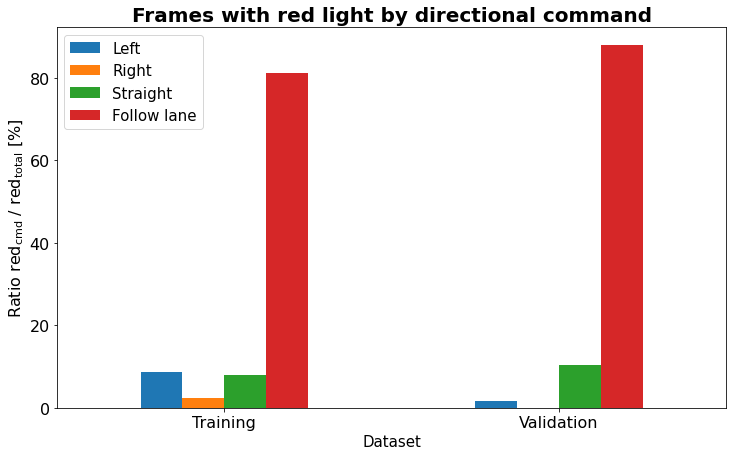

In [89]:
red_lights_t, percentages_t = retrieve_tl_infos_cmd('test_s.txt')
red_lights_v, percentages_v = retrieve_tl_infos_cmd('val_s.txt')

print(percentages)
print(sum(percentages)) #Should be 100%
legends = ['Left', 'Right', 'Straight', 'Follow lane']
x_title = 'Dataset'
plot_labels = ['Training', 'Validation']

metrics = pd.DataFrame(np.array([percentages_t, percentages_v]), columns=legends)
ax = metrics.plot(kind='bar', figsize=(12, 7), legend=True, fontsize=16)
ax.set_xlabel(x_title)
x = np.arange(len(plot_labels))
ax.set_xticks(x)
ax.set_xticklabels(plot_labels, fontsize=16, rotation='horizontal')
ax.set_ylabel("Ratio $red_{cmd}$ / $red_{total}$ [%]", fontsize=16)
plt.title("Frames with red light by directional command", fontsize=20, weight='bold')
plt.savefig('command_rtl_comp.png')

#red_lights, n_red_frames, n_frames, red_l, red_r, red_s, red_f = retrieve_tl_infos('test.txt')
#red_lights, n_red_frames, n_frames, red_l, red_r, red_s, red_f = retrieve_tl_infos('val.txt')

In [67]:
print(len(n_red_frames_t)/sum(n_frames_t))
print(sum(n_red_frames_v)/sum(n_frames_v))

NameError: name 'n_red_frames_t' is not defined

In [ ]:
n_red_frames_t

In [ ]:
avg_tl = np.mean(tl)
avg_rate = np.mean(tl_frames_percentage)
print(avg_tl, avg_rate)

In [ ]:
import seaborn as sns
plt.figure(figsize=(10, 8))
ax = sns.boxplot(data=[tl_t.astype('float'), tl_v.astype('float')])
ax = sns.boxplot(..., labels=["Metric", "Length"])
plt.ylabel("Red traffic lights per episode", size=14)
plt.xlabel("Dataset", size=14)
plt.title("Repartition of red traffic lights in train and val dataset", size=18)
plt.savefig("comprtl.png")

In [ ]:
data = [tl_t, tl_t]
fig7, ax7 = plt.subplots()
ax7.set_title('Multiple Samples with Different sizes')
ax7.boxplot(data)
ax7.legend(labels=['dsdssd','dssd'])
plt.show()

In [ ]:
tl_perc_t

### 1.2 Explore dataset

### 1.2 Inspect traffic lights state

In [ ]:
is_red_tl = []
speed = []
for i in range(int(out['len'].decode())):
    is_red_tl.append(decode_frame(i)['trafficlights'])
    meas = decode_frame(i)['measurements']
    # Measurements: [ox, oy, oz, ori_ox, ori_oy, vx, vy, vz, _, _, _, _, _, _, ax, ay, az, cmd, steer, throttle, brake, manual, gear]
    vel = meas[5:8]
    speed.append(np.linalg.norm(vel))

c = Counter(is_red_tl)
total = sum(c.values())
mapping = {1: 'Red', 0:'Green/Yellow/None'}
print(["{}: {} ({})%".format(mapping.get(k, k), round(v / total * 100, 1), v) for k, v in c.items()])

In [ ]:
fig,ax=plt.subplots()
ax.plot(range(len(is_red_tl)),is_red_tl, 'r--')
ax.set_xlabel("Frame")
ax.set_ylabel("Red light", color='red')

ax2=ax.twinx()
ax2.plot(range(len(is_red_tl)), speed, 'b')
ax2.set_ylabel("Speed [m/s]", color='blue')
plt.show()

In [ ]:
frames_with_red = []
for i in range(len(is_red_tl)):
    if(is_red_tl[i]==1):
        frames_with_red.append(i)
frames_with_red

In [ ]:
frame_of_interest = decode_frame(700)

In [ ]:
rgb=frame_of_interest['rgb']
resized = cv2.resize(rgb, (int(rgb.shape[1]/2), int(rgb.shape[0]/2)), interpolation = cv2.INTER_AREA)
cv2.imwrite('a.png', cv2.cvtColor(resized, cv2.COLOR_RGB2BGR))

In [ ]:
plt.imshow(frame_of_interest['segmentation'][:,:,0]==12) # Carla TL semantic seg channel

In [ ]:
plt.imshow(rgb)
plt.axis('off')
plt.savefig('rgb.png', bbox_inches='tight', pad_inches=0)

In [ ]:
a=frame_of_interest['segmentation'][:, :, 0]
plt.imshow(a)
plt.axis('off')
plt.savefig('seg.png', bbox_inches='tight', pad_inches=0)

In [ ]:
bv=frame_of_interest['birdview']
print(bv.shape[0:2])
b=np.zeros(bv.shape[0:2])
for k in range(bv.shape[2]):
    b[bv[:,:,k] != 0] = k
    #mask[..., i][seg == i] = 1
plt.imshow(b)
plt.axis('off')
plt.savefig('bv.png', bbox_inches='tight', pad_inches=0)

In [ ]:
# Red Traffic light birdview binary mask
plt.imshow(frame_of_interest['birdview'][:,:,2])
plt.axis('off')
plt.savefig('bvtl.png', bbox_inches='tight', pad_inches=0)

In [ ]:
def draw_frame(frame, i):
    font                   = cv2.FONT_HERSHEY_SIMPLEX
    bottomLeftCornerOfText = (int(0.1*frame.shape[0]), int(0.9*frame.shape[0]))
    fontScale              = 1
    fontColor              = [0,255,0]
    fontColor2              = [255,0,0]
    lineType               = 2
    printed_frame = cv2.putText(frame.copy(),'Frame: '+str(i), 
            bottomLeftCornerOfText, font, fontScale, fontColor, lineType);
    return printed_frame

video = cv2.VideoWriter('videos/dataset_23_09_overview.avi', 0, 10, (384, 160))
for i in range(int(out['len'].decode())):
    drawn_frame = draw_frame(decode_frame(i)['rgb'], i)
    video.write(drawn_frame)
video.release()

In [ ]:
#from IPython.core.display import Video
#Video("videos/dataset_23_09_overview.mp4", embed=True)

## 2. Waypoints computation

### 2.1 Tools for transformations

In [ ]:
class Location():
    def __init__(self, x, y, z):
        self.x = x
        self.y = y
        self.z = z

    def __repr__(self,):
        return self.__str__()

    def __str__(self,):
        return "Location(x={}, y={}, z={})".format(self.x, self.y, self.z)

class Rotation():
    def __init__(self, p, y, r):
        self.pitch = p
        self.yaw = y
        self.roll = r

    def __repr__(self,):
        return self.__str__()

    def __str__(self):
        return "Rotation(pitch={}, yaw={}, roll={})".format(self.pitch, self.yaw, self.roll)

class Transform():
    def __init__(self, loc, rot):
        self.location = loc
        self.rotation = rot

    def __repr__(self,):
        return self.__str__()

    def __str__(self,):
        return "Transform({}, {})".format(self.location, self.rotation)

### 2.2 Compute waypoints

In [ ]:
def project_vehicle(x, y, z, ori_x, ori_y, ori_z):
    pos = np.array([x,y,z])
    ori = np.array([ori_x, ori_y, ori_z])
    ori /= np.linalg.norm(ori)  # Make unit vector

    new_pos = pos + 4 * ori
    return converter.convert(np.array([new_pos]))

def interpolate_waypoints(points):
    points = points[:, :2]

    # Fit cubic function through points
    z = np.polyfit(points[:, 0], points[:, 1], 2)
    p = np.poly1d(z)

    # Keep interpolating until we have 5 points
    while points.shape[0] < 5:
        points_2 = np.vstack([points[0], points[:-1]])
        max_id = np.argmax(np.linalg.norm(points-points_2, axis=1))
        _x = np.mean([points[max_id], points_2[max_id]], axis=0)[0]
        points = np.insert(points, max_id, np.array([_x, p(_x)]), 0)

    return points

def get_waypoints(REF_FRAME, world_x, world_y, world_z, ori_x, ori_y, ori_z, GAP=5):
    if decode_frame(REF_FRAME)['trafficlights']:
        vehicle_proj = project_vehicle(world_x, world_y, world_z, ori_x, ori_y, ori_z)
        output = np.array([vehicle_proj[0] for _ in range(5)])
        return output

    output = []
    for i in range(REF_FRAME, (REF_FRAME + (N_STEP+1+BUFFER*GAP)), GAP):
        if len(output) == N_STEP:
            break

        x, y, z = decode_frame(i)['measurements'][:3]
        image_coords = converter.convert(np.array([[x, y, z]]))
        if len(image_coords) > 0:
            output.append(image_coords[0])

    if len(output) < 2:
        # First try with smaller GAP
        if GAP == 5:
            return get_waypoints(REF_FRAME, world_x, world_y, world_z, ori_x, ori_y, ori_z, GAP=1)

        vehicle_proj = project_vehicle(world_x, world_y, world_z, ori_x, ori_y, ori_z)
        output = np.array([vehicle_proj[0] for _ in range(5)])
        return output

    if len(output) >= 2 and len(output) < 5:
        return interpolate_waypoints(np.array(output))

    return np.array(output)

In [ ]:
# REF_FRAME = 800
N_STEP = 5
BUFFER = 40
N_DATASET_CATEGORIES = 9 #(used to be 7)

np.set_printoptions(suppress=True)

all_wp = []
#N = int((len(out)-1)/7)
N = int((len(out)-1)/N_DATASET_CATEGORIES) - 1
for frame in tqdm(range(N - (N_STEP * BUFFER) - 1)):
        # Extract world coordinates from dataset
        world_coords = decode_frame(frame)['measurements']
        world_x, world_y, world_z, ori_x, ori_y, ori_z, _, _, _, cam_x, cam_y, cam_z, cam_yaw, cam_roll, cam_pitch = world_coords[:15]

        sensor_transform = Transform(Location(cam_x, cam_y, cam_z), Rotation(cam_yaw, cam_roll, cam_pitch))
        converter = CoordinateConverter(sensor_transform, fov=120)

        image_coord_wp = get_waypoints(frame, world_x, world_y, world_z, ori_x, ori_y, ori_z)

        all_wp.append(image_coord_wp[:, :2])

## 3. Image processing

### 3.1 Segmentation from 2D to ND 

In [ ]:
N_CLASSES = 13
N_CLASSES_COMBINED = 6
KEEP_CLASSES = {4,6,7,10,12}
N_TRAFFIC_LIGHT_STATES = 1

def seg2D_to_ND_combined(seg, tl_info):
    seg = seg[:, :, 0]  # CARLA stores segmentation values in R channel
    mask = np.zeros((*seg.shape, N_CLASSES_COMBINED + N_TRAFFIC_LIGHT_STATES))

    for i, seg_class in enumerate(KEEP_CLASSES):
        mask[..., i][seg == seg_class] = 1

    TO_COMBINE = set(range(N_CLASSES))-KEEP_CLASSES
    for i in TO_COMBINE:
        mask[..., len(KEEP_CLASSES)] += seg==i

    if tl_info == 0:
        return mask

    # Select channel and set binary mask, 12 is traffic sign class
    mask[..., N_CLASSES_COMBINED][seg == 12] = 1

    return mask

def seg2D_to_ND(seg, tl_info, combine=False):
    """Converts 2D segmentation image to ND array with N boolean masks.
    Where N corresponds to number of segmentation classes."""
    if combine:
        return seg2D_to_ND_combined(seg, tl_info)

    seg = seg[:, :, 0]  # CARLA stores segmentation values in R channel
    mask = np.zeros((*seg.shape, N_CLASSES + N_TRAFFIC_LIGHT_STATES))

    for i in range(N_CLASSES):
        mask[..., i][seg == i] = 1

    if tl_info == 0:
        return mask

    # Select channel and set binary mask, 12 is traffic sign class
    mask[..., N_CLASSES][seg == 12] = 1

    return mask


#UNUSED
def seg2D_to_ND_new(seg, tl_info, combine=False):
    """Converts 2D segmentation image to ND array with N boolean masks.
    Where N corresponds to number of segmentation classes."""
    if combine:
        return seg2D_to_ND_combined(seg, tl_info)

    seg = seg[:, :, 0]  # CARLA stores segmentation values in R channel
    mask = np.zeros((*seg.shape, N_CLASSES))

    # Do not add traffic light state yet
    for i in range(N_CLASSES-1):
        mask[..., i][seg == i] = 1

    # Add traffic light state, 12 is traffic sign class
    mask[..., 12][seg == 12] = tl_info

    return mask

In [ ]:
N_CLASSES=5
a= np.random.randint(N_CLASSES, size=(10,4))
a

In [ ]:
mask = np.zeros((*a.shape, N_CLASSES))
mask.shape

# Do not add traffic light state yet
for i in range(N_CLASSES):
    mask[..., i][a == i] = 5
    print(mask[:,:,i])

In [ ]:
mask[:,:, 3]

In [ ]:
tc = seg2D_to_ND_combined(decode_frame(N)['segmentation'], decode_frame(N)['trafficlights'])
plt.imshow(tc[..., -2])
plt.show()
tc.shape

In [ ]:
t = seg2D_to_ND(decode_frame(N)['segmentation'], decode_frame(N)['trafficlights'], combine=False)
plt.imshow(t[..., -2])
plt.show()
t.shape

### 3.2 Down-scaling

In [ ]:
def down_scale(img):
    new_shape = (img.shape[0]//2, img.shape[1]//2)
    img = np.moveaxis(img, 1, 0)
    img = cv2.resize(img.astype(np.float32), new_shape)
    img = np.moveaxis(img, 1, 0)

    return img

### 3.3 Augmentation sequence

In [ ]:
import imgaug.augmenters as iaa
import imgaug as ia
from imgaug.augmentables import Keypoint, KeypointsOnImage

#def affine(image):
#    aug = iaa.Affine(translate_px={"x": (-30, 30), "y": (0, -5)}, scale={"x": (1, 1.15), "y": (1, 1.15)}, mode='reflect')
#    return aug(images=image)

# def dropout(image):
#     aug = iaa.Dropout(p=(0, 0.1), per_channel=0.5)
#     return aug(images=image)

# def blur(image):
#     aug = iaa.MotionBlur(k=5, angle=[-90, 0, 90])
#     return aug(images=image)

sometimes = lambda aug: iaa.Sometimes(0.33, aug)
# seq = iaa.Affine(translate_px={"x": (-15, 15), "y": (0, -5)}, scale={"x": (1, 1.15), "y": (1, 1.15)}, mode='reflect')
seq = iaa.Sequential(
        [
            sometimes(
                iaa.Affine(
                    translate_px={"x": (-15, 15), "y": (0, -5)},
                    scale={"x": (1, 1.15), "y": (1, 1.15)},
                    mode='reflect')
            ),
            sometimes(
                iaa.Dropout(
                    p=(0, 0.1),
                    per_channel=0.5)
            ),
            sometimes(
                iaa.MotionBlur(
                    k=(3,5),
                    angle=[-90, 0, 90])
            )
        ],
    random_order=True)

In [ ]:
# Create Keypoint objects from waypoints so that we can apply to them the same augmentation sequence as the image
def points_to_keypoints(points, shape):
    kps = KeypointsOnImage([
        Keypoint(x=points[0][0], y=points[0][1]),
        Keypoint(x=points[1][0], y=points[1][1]),
        Keypoint(x=points[2][0], y=points[2][1]),
        Keypoint(x=points[3][0], y=points[3][1]),
        Keypoint(x=points[4][0], y=points[4][1])
        ], shape=shape)

    return kps

# Apply augmentation sequence to both image and waypoints
def augment_image(image, points, redo=0):
    if redo >= 5:
        print("J")
        return image, points

    image_aug, p_aug = seq(image=down_scale(image), keypoints=points_to_keypoints(points/2, (80, 192)))
    temp = p_aug.to_xy_array()
    if not np.all((temp[:, 0] <= 192) & (temp[:, 1] <= 80)):
        return augment_image(image, points, redo=redo+1)

    return image_aug, temp

In [ ]:
# view image (before/after) augmentation

# def plot_augmentation(original, augmented):
#     plt.figure(figsize=(12,6))
#     plt.title("Original")
#     plt.imshow(original)
#     plt.show()

#     plt.figure(figsize=(12,6))
#     plt.title("Augmented")
#     plt.imshow(augmented)
#     plt.show()
    
# # Intermediate overview
# b = decode_frame(1)['segmentation']
# b = seg2D_to_ND(b, 0)
# b = down_scale(b)

# plot_augmentation(b[:, :, 6:9], seq(image=b)[:, : ,6:9])

In [ ]:
# view waypoints after augmentation

# for i in range(0, 500, 100):
#     temp_img = decode_frame(i)['segmentation']
#     temp_img = seg2D_to_ND(temp_img, 0)
#     img_aug, points_aug = augment_image(temp_img, all_wp[i])
#     plt.scatter(points_aug[:, 0], points_aug[:, 1])
#     plt.show()

In [ ]:
imgs, new_kps = seq(images=[down_scale(decode_frame(i)['segmentation'][:, :, 0]) for i in range(245, 255, 10)], keypoints=[points_to_keypoints(all_wp[i]/2, (80, 192)) for i in range(0, 100, 10)])
for img, new_kp in zip(imgs, new_kps):
    plt.imshow(img)
    points_temp = new_kp.to_xy_array()
    plt.scatter(points_temp[:, 0], points_temp[:, 1])
    plt.show()

## 4. Final results

### 4.1 View final results

In [ ]:
def plot_results(ref_frame_id, next_frame_id, locations):
    plt.title("NEXT FRAME ({})".format(next_frame_id))
    plt.imshow(decode_frame(next_frame_id)['segmentation'][:, :, 0])
    plt.show()

    plt.figure(figsize=(20,12))
    plt.title("REF FRAME ({}) WITH PROJECTIONS".format(ref_frame_id))
    plt.imshow(decode_frame(ref_frame_id)['segmentation'][:, :, 0])
    for i, location in enumerate(locations):
        plt.scatter(location[:, 0], location[:, 1], label="projection {}".format(i))

    plt.legend()
    plt.show()

In [ ]:
#plot_results(N, i, [all_wp[N]])
plot_results(155, 160, [all_wp[155]])
# plt.imshow(down_scale(decode_frame(N)['segmentation'][:, :, 0]))
# temp_wp = all_wp[N].copy()

# temp_wp /= 2
# # temp_wp[:, 0] /= 2
# # temp_wp[:, 1] /= 2

# plt.scatter(temp_wp[:, 0], temp_wp[:, 1], s=1)
# plt.scatter(temp_wp[:, 0], temp_wp[:, 1]-2, s=1)
# plt.show()

### 4.2 Save final results

In [ ]:
R = 1

#video = cv2.VideoWriter('imgs_noise_test/test_video_noise_2.avi', 0, 10, (192, 80))
video = cv2.VideoWriter('noise/test_video_noise_2.avi', 0, 10, (192, 80))

for i, wp in tqdm(enumerate(all_wp)):
    # Down-scaling image (x0.5)
    img = down_scale(decode_frame(i)['segmentation'][:, :, 0])
    # Accordingly down-scaling waypoints (x0.5)
    for x, y in wp:
        x = int(x/2)
        y = int(y/2)
        img[y - R: y + R + 1, x - R: x + R + 1] = 12
    
    norm_image = cv2.normalize(img, None, alpha=0, beta=250, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
    imgC = cv2.applyColorMap(norm_image, cv2.COLORMAP_JET)
    #plt.imshow(imgC)
    #plt.show()
    video.write(imgC)
    #cv2.imwrite('imgs_noise_test/frame_{}.png'.format(i),  imgC)
    cv2.imwrite('noise/frame_{}.png'.format(i),  imgC)
    
video.release()

## 5. Playground

In [ ]:
PIXEL_OFFSET = 10

def draw_msra_gaussian(heatmap, center, sigma):
    tmp_size = sigma * 3
    mu_x = int(center[0] + 0.5)
    mu_y = int(center[1] + 0.5)
    w, h = heatmap.shape[0], heatmap.shape[1]
    ul = [int(mu_x - tmp_size), int(mu_y - tmp_size)]
    br = [int(mu_x + tmp_size + 1), int(mu_y + tmp_size + 1)]
    if ul[0] >= h or ul[1] >= w or br[0] < 0 or br[1] < 0:
        return heatmap
    size = 2 * tmp_size + 1
    x = np.arange(0, size, 1, np.float32)
    y = x[:, np.newaxis]
    x0 = y0 = size // 2
    g = np.exp(- ((x - x0) ** 2 + (y - y0) ** 2) / (2 * sigma ** 2))
    g_x = max(0, -ul[0]), min(br[0], h) - ul[0]
    g_y = max(0, -ul[1]), min(br[1], w) - ul[1]
    img_x = max(0, ul[0]), min(br[0], h)
    img_y = max(0, ul[1]), min(br[1], w)
    heatmap[img_y[0]:img_y[1], img_x[0]:img_x[1]] = np.maximum(
      heatmap[img_y[0]:img_y[1], img_x[0]:img_x[1]],
      g[g_y[0]:g_y[1], g_x[0]:g_x[1]])
    return heatmap


def world_to_pixel(
        x,y,ox,oy,ori_ox, ori_oy,
        pixels_per_meter=5, offset=(-80,160), size=320, angle_jitter=15):
    pixel_dx, pixel_dy = (x-ox)*pixels_per_meter, (y-oy)*pixels_per_meter

    pixel_x = pixel_dx*ori_ox+pixel_dy*ori_oy
    pixel_y = -pixel_dx*ori_oy+pixel_dy*ori_ox

    pixel_x = size-pixel_x

    return np.array([pixel_x, pixel_y]) + offset

def test_get_item(bird_view, segmentation, tl_info, measurement, segs=False):
    crop_x_jitter = 5
    crop_y_jitter = 0
    angle_jitter =  5
    img_size = 320
    crop_size = 192
    crop_size_y = 80
    down_ratio = 4
    gap = 5
    gaussian_radius = 1.0
    n_step = 5
    segmentation = seg2D_to_ND(segmentation, tl_info, combine=False)
    rgb_image = None

    ox, oy, oz, ori_ox, ori_oy, vx, vy, vz, _, _, _, _, _, _, ax, ay, az, cmd, steer, throttle, brake, manual, gear  = measurement
    speed = np.linalg.norm([vx,vy,vz])

    oangle = np.arctan2(ori_oy, ori_ox)
    delta_angle = np.random.randint(-angle_jitter,angle_jitter+1)
    dx = np.random.randint(-crop_x_jitter,crop_x_jitter+1)
    dy = np.random.randint(0,crop_y_jitter+1) - PIXEL_OFFSET

    o_camx = ox + ori_ox*2
    o_camy = oy + ori_oy*2

#     if segs:
    pixel_ox = 192
    pixel_oy = 130

    # RANDOM WARPING
    segmentation = cv2.warpAffine(
            segmentation,
            cv2.getRotationMatrix2D((pixel_ox,pixel_oy), delta_angle, 1.0),
            segmentation.shape[1::-1], flags=cv2.INTER_LINEAR)

    center_x, center_y = pixel_ox, pixel_oy-crop_size_y//2
    segmentation = segmentation[
            dy+center_y-crop_size_y//2:dy+center_y+crop_size_y//2,
            dx+center_x-crop_size//2:dx+center_x+crop_size//2]

    angle = np.arctan2(ori_oy, ori_ox) + np.deg2rad(delta_angle)
    ori_ox, ori_oy = np.cos(angle), np.sin(angle)

    locations = []
    orientations = []

    # LOCATION MODIFICATION
    for dt in range(gap, gap*(n_step+1), gap):
        f_measurement = decode_frame(N+dt)['measurements']
        x, y, z, ori_x, ori_y = f_measurement[:5]
#         x, y, z, ori_x, ori_y, ori_z = f_measurement[:6]
#         rot, loc = rotation(ori_x, ori_y, ori_z), np.array([x, y, z])
#         inv_m = get_inv_matrix(rot, loc)

        pixel_y, pixel_x = world_to_pixel(x,y,ox,oy,ori_ox,ori_oy,size=160, offset=(-80,192))
        pixel_x = pixel_x - (384-crop_size)//2
        pixel_y = crop_size_y - (160-pixel_y)+70

        pixel_x -= dx
        pixel_y -= dy

        angle = np.arctan2(ori_y, ori_x) - np.arctan2(ori_oy, ori_ox)
        ori_dx, ori_dy = np.cos(angle), np.sin(angle)

        locations.append([x, y, z])
        orientations.append([ori_dx, ori_dy])


    # Create mask
    output_size = crop_size // down_ratio
    heatmap_mask = np.zeros((n_step, output_size, output_size), dtype=np.float32)
    regression_offset = np.zeros((n_step,2), np.float32)
    indices = np.zeros((n_step), dtype=np.int64)

    for i, (pixel_x, pixel_y, _) in enumerate(locations):
        center = np.array(
                [pixel_x / down_ratio, pixel_y / down_ratio],
                dtype=np.float32)
        center = np.clip(center, 0, output_size-1)
        center_int = np.rint(center)

        draw_msra_gaussian(heatmap_mask[i], center_int, gaussian_radius)
        regression_offset[i] = center - center_int
        indices[i] = center_int[1] * output_size + center_int[0]
    out = []
    out.append([segmentation, bird_view, np.array(locations), cmd, speed])
#     else:
    pixel_ox = 160
    pixel_oy = 260


    # RANDOM WARPING
    bird_view = cv2.warpAffine(
            bird_view,
            cv2.getRotationMatrix2D((pixel_ox,pixel_oy), delta_angle, 1.0),
            bird_view.shape[1::-1], flags=cv2.INTER_LINEAR)


    # RANDOM CROPPING
    center_x, center_y = 160, 260-crop_size//2
    bird_view = bird_view[
            dy+center_y-crop_size//2:dy+center_y+crop_size//2,
            dx+center_x-crop_size//2:dx+center_x+crop_size//2]

    angle = np.arctan2(ori_oy, ori_ox) + np.deg2rad(delta_angle)
    ori_ox, ori_oy = np.cos(angle), np.sin(angle)

    locations = []
    orientations = []

    # LOCATION MODIFICATION
    for dt in range(gap, gap*(n_step+1), gap):
        f_measurement = decode_frame(N+dt)['measurements']
        x, y, z, ori_x, ori_y = f_measurement[:5]

#         x, y, z, ori_x, ori_y, ori_z = f_measurement[:6]
#         rot, loc = rotation(ori_x, ori_y, ori_z), np.array([x, y, z])
#         inv_m = get_inv_matrix(rot, loc)

        pixel_y, pixel_x = world_to_pixel(x,y,ox,oy,ori_ox,ori_oy,size=img_size)
        pixel_x = pixel_x - (img_size-crop_size)//2
        pixel_y = crop_size - (img_size-pixel_y)+70

        pixel_x -= dx
        pixel_y -= dy

        angle = np.arctan2(ori_y, ori_x) - np.arctan2(ori_oy, ori_ox)
        ori_dx, ori_dy = np.cos(angle), np.sin(angle)

        locations.append([x, y, z])
        orientations.append([ori_dx, ori_dy])


    # Create mask
    output_size = crop_size // down_ratio
    heatmap_mask = np.zeros((n_step, output_size, output_size), dtype=np.float32)
    regression_offset = np.zeros((n_step,2), np.float32)
    indices = np.zeros((n_step), dtype=np.int64)

    for i, (pixel_x, pixel_y, _) in enumerate(locations):
        center = np.array(
                [pixel_x / down_ratio, pixel_y / down_ratio],
                dtype=np.float32)
        center = np.clip(center, 0, output_size-1)
        center_int = np.rint(center)

        draw_msra_gaussian(heatmap_mask[i], center_int, gaussian_radius)
        regression_offset[i] = center - center_int
        indices[i] = center_int[1] * output_size + center_int[0]

    out.append([segmentation, bird_view, np.array(locations), cmd, speed])
    return np.array(out)

In [ ]:
N_FIG = 6
out_temp = []
for i in range(N_FIG):
    N = i + 10
    temp = test_get_item(decode_frame(N)['birdview'], decode_frame(N)['segmentation'], decode_frame(N)['trafficlights'], decode_frame(N)['measurements'])
    out_temp.append(temp)

out_temp = np.array(out_temp)

In [ ]:
REF_FRAME = 0
NEXT_FRAME = 2

In [ ]:
# Extract world coordinates from dataset
world_coords = decode_frame(REF_FRAME)['measurements']
world_x, world_y, world_z, _, _, _, _, _, cam_x, cam_y, cam_z, cam_yaw, cam_roll, cam_pitch = world_coords[:14]

print("CURRENT LOCATION:", world_x, world_y, world_z)
# Get sensor transform
sensor_transform = Transform(Location(cam_x, cam_y, cam_z), Rotation(cam_yaw, cam_roll, cam_pitch))

In [ ]:
plt.figure(figsize=(12,60))

for i in range(N_FIG):
    # NEW SEG
    plt.subplot(N_FIG, 2, (i*2)+1)
    plt.imshow(out_temp[i][0][0][..., 6:9])
    plt.scatter(out_temp[i][0][2][:,0], out_temp[i][0][2][:,1])

    # OLD BIRDVIEW
    plt.subplot(N_FIG, 2, (i*2)+2)
    plt.imshow(out_temp[i][1][1][:, :, :3])
    plt.scatter(out_temp[i][1][2][:,0], out_temp[i][1][2][:,1])

plt.show()

In [ ]:
plt.figure(figsize=(12,20))

for i in range(N_FIG):
    # NEW SEG
    plt.subplot(N_FIG, 2, (i*2)+1)
    plt.imshow(out_temp[i][0][0][..., 6:9])
    plt.scatter(out_temp[i][0][2][:,0], out_temp[i][0][2][:,1])

    # OLD BIRDVIEW
    plt.subplot(N_FIG, 2, (i*2)+2)
    plt.imshow(out_temp[i][1][1][:, :, :3])
    plt.scatter(out_temp[i][1][2][:,0], out_temp[i][1][2][:,1])

plt.show()

In [ ]:
# Segemetnation tests

for i in range(1000):
    temp_img = decode_frame(i)['segmentation']
    temp_tl = decode_frame(i)['trafficlights']
    
    if temp_tl:
        print(i)
        break
    

temp_img = decode_frame(759)['segmentation']
temp_tl = decode_frame(759)['trafficlights']

plt.title("Original")
plt.imshow(temp_img[:, :, 0])
plt.show()

plt.title("OLD TL state channel")
plt.imshow(seg2D_to_ND(temp_img, 1)[:, :, 13:14])
plt.show()

plt.title("OLD TL channel")
plt.imshow(seg2D_to_ND(temp_img, 1)[:, :, 12:13])
plt.show()



plt.title("NEW TL (state) channel")
plt.imshow(seg2D_to_ND_new(temp_img, 0)[:, :, 12:13])
plt.show()


plt.imshow(seg2D_to_ND_new(temp_img, 0)[:, :, 10:13])
plt.show()